# **Detection with Optical Flow**

In this notebook we will explore a  method of moving object detection via Farneback Optical Flow. Optical Flow describes the motion of pixel intensities across a sequence of images. The Farneback method allows us to compute the motion of all pixels in an image, the fact that it computes the flow for all pixels makes it a Dense Optical Flow method.

In [30]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# from motion_detection_utils import *

### Visualize the data

We are using highway traffic scene data. The camera does not move and the cars are all moving, both of which make it ideal to use Optical Flow for object detection

In [3]:
# get properly sorted images
data_path = 'images'
# image_paths = sorted(glob(f"{data_path}/*.jpg"), key=lambda x:float(re.findall("(\d+)",x)[0]))
image_paths = []
for image_name in os.listdir(data_path):
    if '.jpg' in image_name:
        image_paths.append(f'{data_path}/{image_name}')

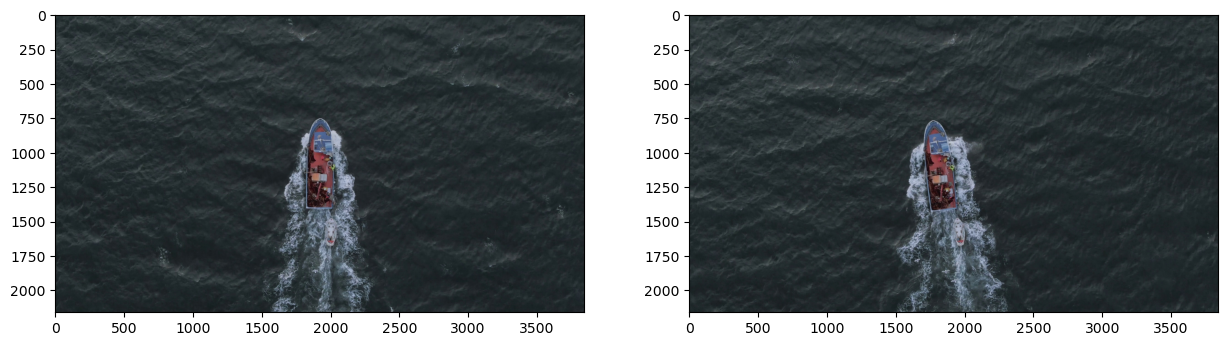

In [4]:
idx = 56

frame1_bgr = cv2.imread(image_paths[idx])
frame2_bgr = cv2.imread(image_paths[idx+1])

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB))
plt.show()

We can see that the objects in the image get smaller as they are further away, this means that we can expect a larger pixel displacement for closer objects and a smaller pixel displacement for objects that are further away. The general approach for moving object detection with optical flow is to use movement threshold to detect movement. This will not be a global threshold, since objects are expected to move at different pixel distances depending on where they are located within the image. We will need to implement a stepped threshold based on the image

### Compute the Farneback Optical Flow between two consecutive frames

In [5]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow


def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow 
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

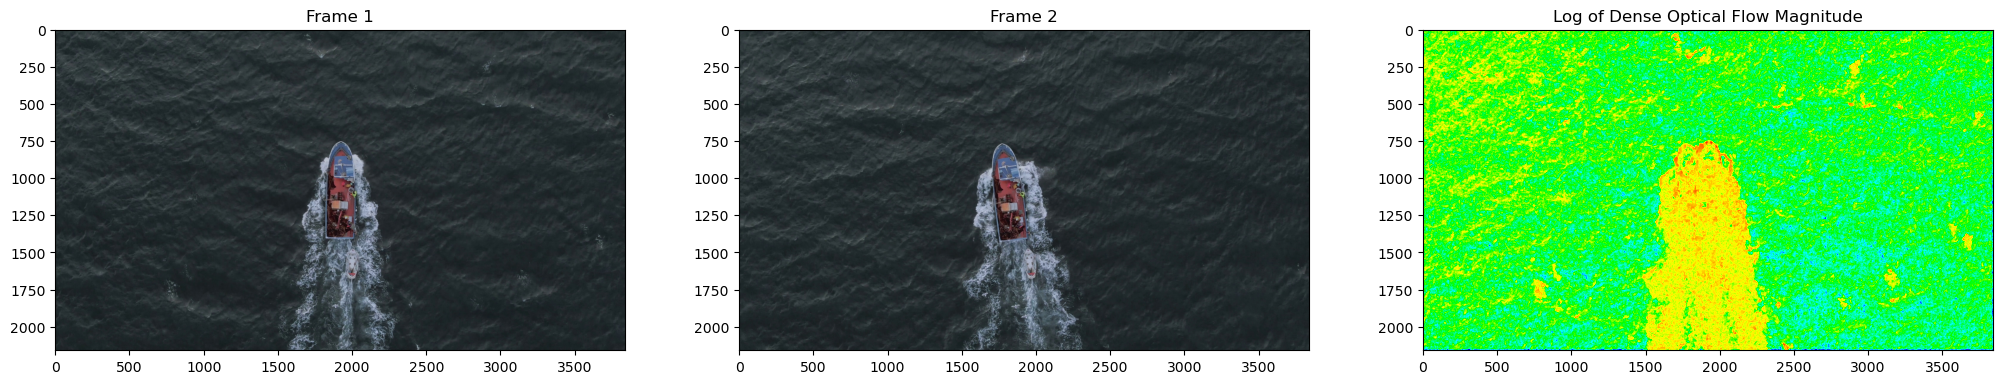

In [6]:
# compute dense optical flow
flow = compute_flow(frame1_bgr, frame2_bgr)

# separate into magntiude and angle
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


img1_rgb = cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)

# display
fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'
ax[2].set_title('Log of Dense Optical Flow Magnitude')
plt.show()

### Use the Optical Flow to get an Image Mask for Detections

In [7]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    return motion_mask

In [8]:
mag.min(), mag.max()

(5.9516353e-08, 276.90335)

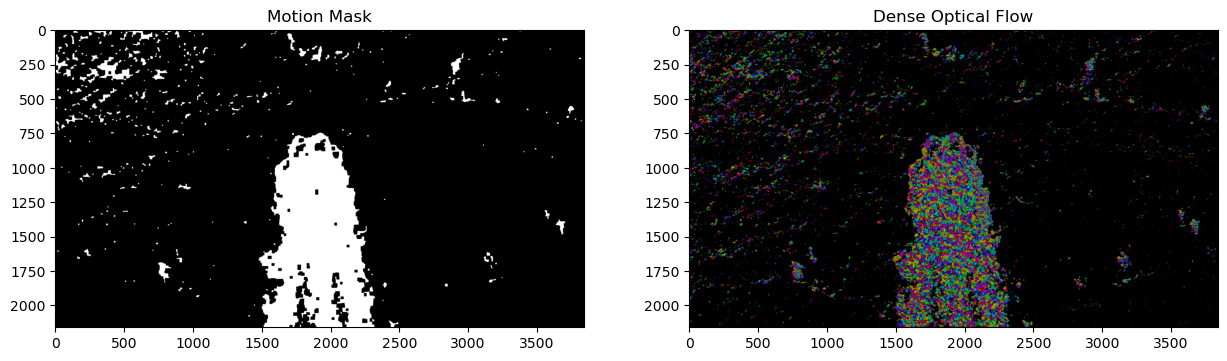

In [11]:
# get optical flow visualization
rgb = get_flow_viz(flow)

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 2160)].repeat(3840, axis=-1)   # unnormalized threshold

# get motion mask
mask = get_motion_mask(mag, motion_thresh=motion_thresh)  # unnormalized threshold


"""
it's usually a good idea to NORMALIZE! Thanks to https://github.com/ErdosG for pointing this out!
Normalization allows us to be more consistent across data from different domains, this means
it helps us generalize better.
Try uncommenting and running the code below to experiment with normalization
"""
# motion_thresh = np.c_[np.linspace(1e-6, 3e-2, 1080)].repeat(1920, axis=-1)  # normalized threshold
# mask = get_motion_mask(mag/mag.max(), motion_thresh=motion_thresh)          # normalized threshold

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[1].imshow(rgb*50) # scale RGB to see the noise
ax[1].set_title("Dense Optical Flow")
plt.show()

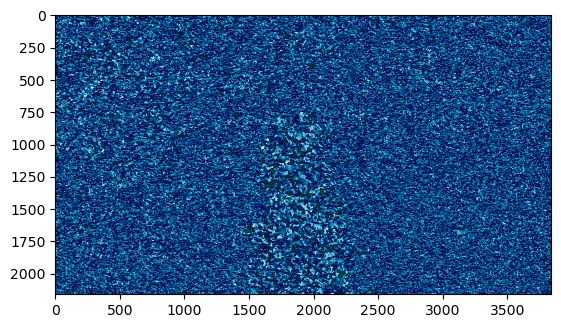

In [12]:
plt.imshow(ang, cmap='ocean') # 'gist_earth_r', 'rainbow_r', 'twilight_r'
plt.show()

Display the Motion threshold

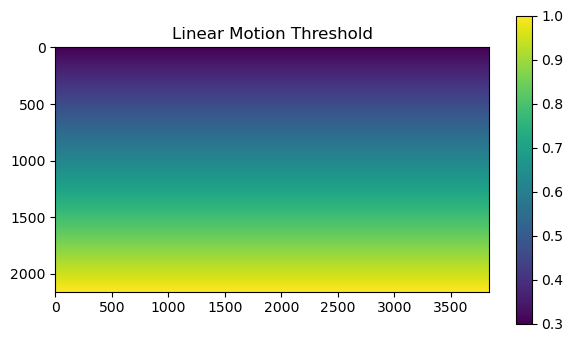

In [13]:
plt.figure(figsize=(7,4))
plt.imshow(motion_thresh)
plt.title("Linear Motion Threshold");
plt.colorbar()
plt.show()

Notice how using Dense Optical Flow allows us to obtain a mask over all moving objects, however the contours around multiple closely spaced objects will be continuous leading to more large bounding boxes around groups of closely spaced objects

## **Get Detections from Motion Mask**

Next we will find the contours on our image mask. These contours will help find the large moving objects that we wish to detect.

Then we will use the detected contours to find the moving objects. To do this we will use the "boundingRect" function to obtain bounding box locations of the detections. You may have noticed that the image mask was not perfectly denoised, instead of denoising the image mask we will use the area of each detected bounding box as a threshold to determine the initial detectons. We will also incorporate the estimate flow angle to help filter out detections. If the flow angle for a given contour has too much variation, then we will not keep it as a detection.

In [14]:
def get_contour_detections_2(mask, ang=ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores 
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

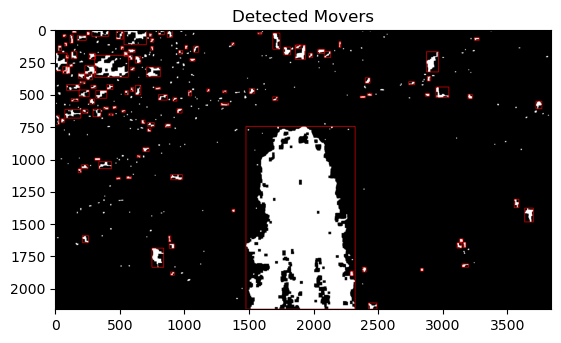

In [15]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections_2(mask, ang, angle_thresh=2, thresh=400)
# detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers")
plt.show()

In [16]:
def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be soirted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area 
                    [[x1,y1,x2,y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained 
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

## **Perform Non-Maximal Suppression**

In [17]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(117, 115)

Now we will draw our final detections on the image

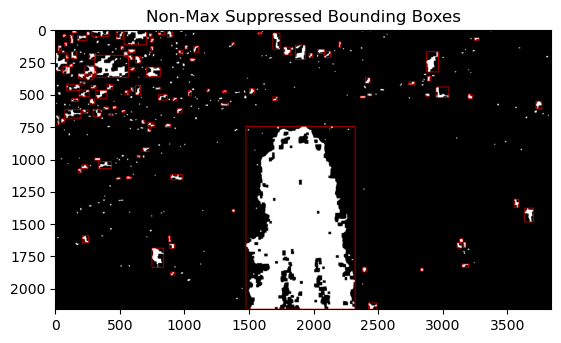

In [18]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes")
plt.show()

In [28]:
def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)

def get_contour_detections(mask, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the mask. 
        Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

def create_gif_from_images(save_path : str, image_path : str, ext : str) -> None:
    ''' creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    '''
    ext = ext.replace('.', '')
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=50, loop=0)

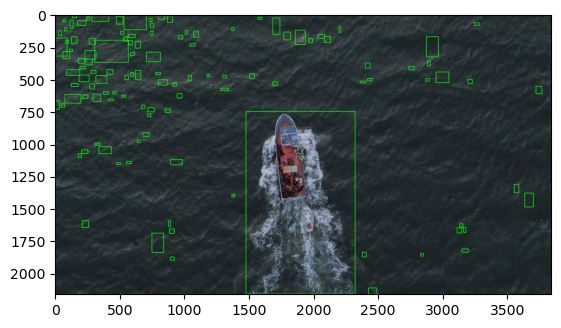

In [23]:
frame2 = img2_rgb.copy()
draw_bboxes(frame2, nms_bboxes)
plt.imshow(frame2)
plt.show()

Now that we have our method, we can place everything together

In [24]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            motion_thresh - Minimum flow threshold for motion
            bbox_thresh - Minimum threshold area for declaring a bounding box 
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get optical flow
    flow = compute_flow(frame1, frame2)

    # separate into magntiude and angle
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh, kernel=mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)
    

## Run on all Frames

In [ ]:
video_frames = []

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 2160)].repeat(3840, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections(frame1_bgr, 
                                frame2_bgr, 
                                motion_thresh=motion_thresh, 
                                bbox_thresh=400, 
                                nms_thresh=0.1, 
                                mask_kernel=kernel)
                                
    # draw bounding boxes on frame
    draw_bboxes(frame2_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame2_bgr)
    plt.axis('off')
    fig.savefig(f"temp_part2/frame_{idx}.png")
    plt.close()

    # OPTIONAL append to list for video
    video_frames.append(frame2_bgr)

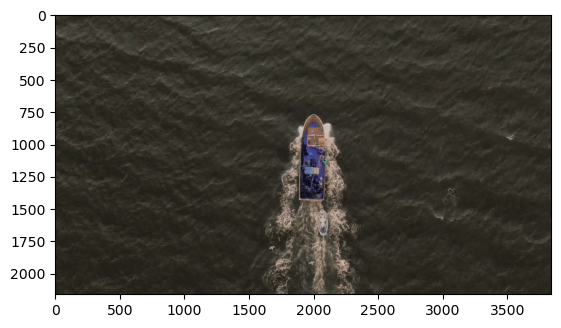

In [27]:
plt.imshow(frame2_bgr)
plt.show()

### Make GIF

In [31]:
create_gif_from_images('optical_flow.gif', 'temp', '.png')

### OPTIONAL: Make Video

In [38]:
out = cv2.VideoWriter('optical_flow.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25, (1920, 1080))

for img in video_frames:
    out.write(img)

out.release()
del out